In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import daft

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import theano
import theano.tensor as tt
theano.config.warn.round=False

In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [5]:
sns.set_context('notebook')
sns.set_style('darkgrid')

-----

# Mixture models

We can construct very flexible new distributions using mixtures of other distributions. In fact, we can construct mixtures of not just distributions, but of regression models, neural networks etc, making this a very powerful framework. We consider finite and Dirichlet Process (DP) mixtures, and see basic ideas for how to work with mixtures in `pymc3`.

## The Categorical distribution

This is just the extension of the Bernoulli distribuiotn to more than 2 states.

In [6]:
cat = stats.multinomial(1, [0.1, 0.2, 0.3, 0.4])

In [7]:
cat.rvs(10)

array([[0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0]])

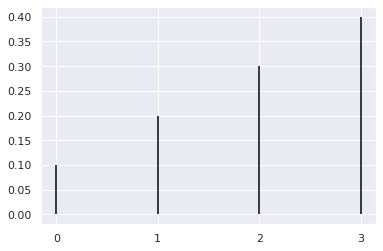

In [8]:
x = range(4)
plt.vlines(x, 0, cat.p)
plt.xticks(range(4))
pass

## The Dirichlet distribution

The code to visualize Dirichlet distributions in barycentric coordinates is from this [blog](http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/).

In [9]:
from functools import reduce
import matplotlib.tri as tri
from math import gamma
from operator import mul

In [10]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):

        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
        
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])

def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

<Figure size 432x288 with 0 Axes>

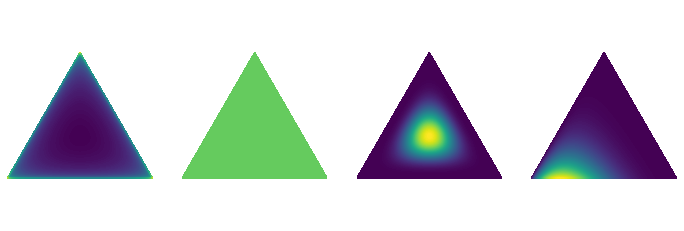

In [11]:
ks = (
    [0.999, 0.999, 0.999],
    [1,1,1],
    [5,5,5],
    [5,2,1],
)

plt.viridis()
fig = plt.figure(figsize=(12,4))
for i, k in enumerate(ks):
    plt.subplot(1,4,i+1)
    draw_pdf_contours(Dirichlet(k))

### Samples from Dirichlet distribution

In [12]:
n = 20
s = stats.dirichlet.rvs(alpha=[7,7,7], size=n).T

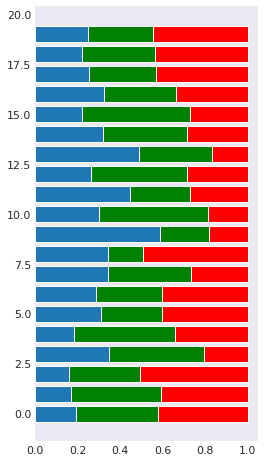

In [13]:
plt.figure(figsize=(4, n*0.4))
with plt.style.context('seaborn-dark'):
    plt.barh(range(n), s[0])
    plt.barh(range(n), s[1], left=s[0], color='g')
    plt.barh(range(n), s[2], left=s[0]+s[1], color='r')
pass

## Finite Gaussian Mixture Model

### Data

In [14]:
np.random.seed(1)
data = np.r_[np.random.normal(-6, 2, 500), 
          np.random.normal(0, 1, 200), 
          np.random.normal(4, 1, 300)]
n = data.shape[0]

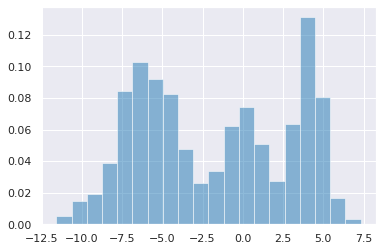

In [15]:
plt.hist(data, bins=20, normed=True, alpha=0.5)
pass

In [16]:
data.shape

(1000,)

### Explicit latent variable

In [17]:
k = 3

with pm.Model() as gmm1:
    p = pm.Dirichlet('p', a=np.ones(k))
    z = pm.Categorical('z', p=p, shape=data.shape[0])
    μ = pm.Normal('μ', 0, 10, shape=k)
    σ = pm.InverseGamma('τ', 1, 1, shape=k)
        
    y = pm.Normal('y', mu=μ[z], sd=σ[z], observed=data)

In [18]:
with gmm1:
    trace = pm.sample(n_init=10000, tune=1000, random_seed=123)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [τ, μ, p]
>CategoricalGibbsMetropolis: [z]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [07:07<00:00, 14.05draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [19]:
trace.varnames

['p_stickbreaking__', 'z', 'μ', 'τ_log__', 'p', 'τ']

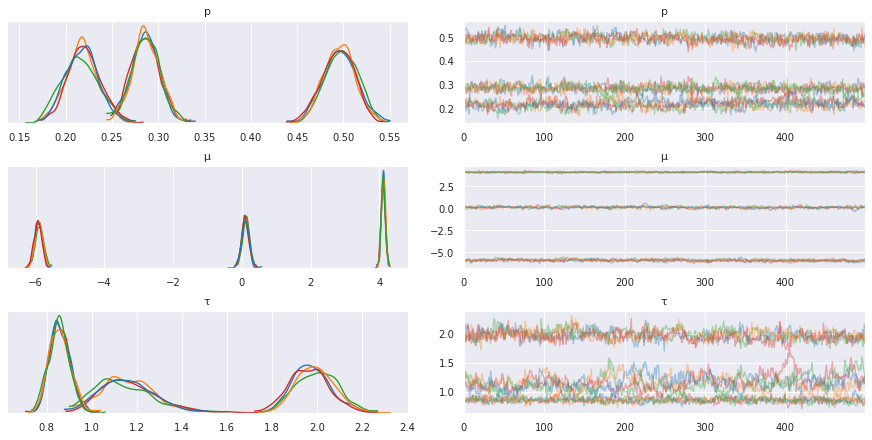

In [20]:
pm.traceplot(trace, varnames=['p', 'μ', 'τ'])
pass

100%|██████████| 10/10 [00:00<00:00, 105.97it/s]


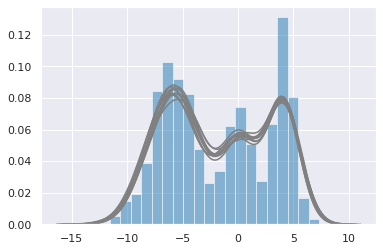

In [21]:
with gmm1:
    ppc = pm.sample_posterior_predictive(trace, samples=10)

plt.hist(data, bins=20, normed=True, alpha=0.5)
for i in range(10):
    sns.distplot(ppc['y'][i], hist=False, color='grey')

Note that the sampler is quite slow and convergence is poor. This is due to the need to sample over the discrete latent variable $z$. We can improve convergence by marginalizing out $z$.

### Marginalization

$$
f(x | p) = \sum_{i=1}^{k} p_i N(\mu, \sigma)
$$


Origina model

```python
with pm.Model() as gmm1:
    p = pm.Dirichlet('p', a=np.ones(k))
    z = pm.Categorical('z', p=p, shape=data.shape[0])
    μ = pm.Normal('μ', 0, 10, shape=k)
    σ = pm.InverseGamma('τ', 1, 1, shape=k)
        
    y = pm.Normal('y', mu=μ[z], sd=σ[z], observed=data)
```

In [22]:
k = 3

with pm.Model() as gmm2:
    p = pm.Dirichlet('p', a=np.ones(k))
    μ = pm.Normal('μ', 0, 10, shape=k)
    σ = pm.InverseGamma('τ', 1, 1, shape=k)
        
    y = pm.NormalMixture('y', p, mu=μ, sd=σ, observed=data)

In [23]:
with gmm2:
    trace = pm.sample(n_init=10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, μ, p]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:08<00:00, 730.06draws/s] 
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


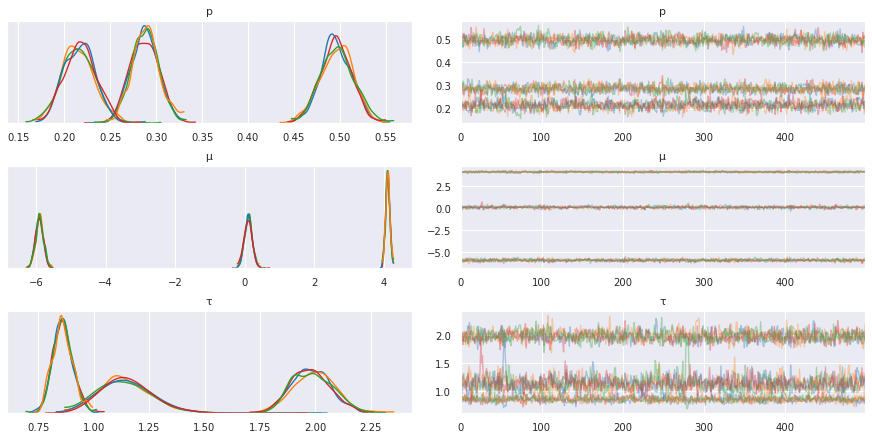

In [24]:
pm.traceplot(trace, varnames=['p', 'μ', 'τ'])
pass

100%|██████████| 10/10 [00:00<00:00, 19.86it/s]


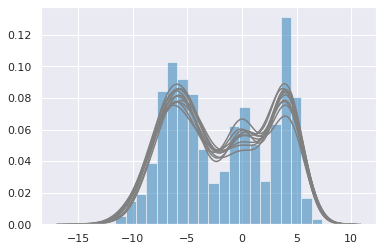

In [25]:
with gmm2:
    ppc = pm.sample_posterior_predictive(trace, samples=10)

plt.hist(data, bins=20, normed=True, alpha=0.5)
for i in range(10):
    sns.distplot(ppc['y'][i], hist=False, color='grey')

## Dirichlet process

### Samples from DP

In [26]:
def sbp0(α, k, base=stats.norm(0,1)):
    β = stats.beta.rvs(1, α, size=k)
    w = β * np.r_[[1], (1 - β[:-1]).cumprod()]
    x = base.rvs(size=k)
    return w, x

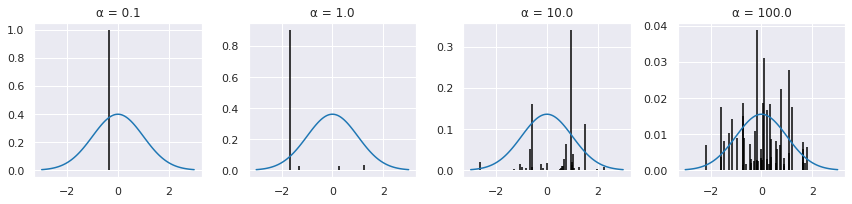

In [27]:
k = 50

xp = np.linspace(-3,3,100)
np.random.seed(123)
plt.figure(figsize=(12,3))
for i, α in enumerate([0.1, 1,10,100]):
    plt.subplot(1, 4, i+1)
    w, x = sbp0(α, k)
    plt.vlines(x, 0, w)
    plt.plot(xp, w.max()*stats.norm(0,1).pdf(xp))
    plt.title('α = %.1f' % α)
plt.tight_layout()

### DP mixture model

#### Generative process

In [28]:
np.random.seed(123)
α = 1
k = 20

w, x = sbp0(α, k)
dist = stats.norm(x, 0.5)

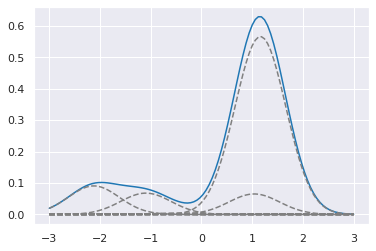

In [29]:
xp = np.transpose([np.linspace(-3,3,100)]*k)
plt.plot(xp[:,0], (w*dist.pdf(xp)).sum(1))
plt.plot(xp, w*dist.pdf(xp), c='grey', ls='--')
pass

### Fitting to data

In [30]:
def sbp(α, k=20):
    """Stick breaking process geneerator."""
    
    β = pm.Beta('β', 1, α, shape=k)
    w = β * pm.math.concatenate([[1], (1 - β[:-1]).cumprod()])
    return w

In [31]:
with pm.Model() as dpgmm:
    α = pm.Gamma('α', 1, 1)
    p = pm.Deterministic('p', sbp(α))
    μ = pm.Normal('μ', 
                  np.linspace(data.min(), data.max(), k), 
                  sd=10, 
                  shape=k, 
                  transform=pm.distributions.transforms.ordered)
    σ = pm.InverseGamma('τ', 1, 1, shape=k)
        
    y = pm.NormalMixture('y', p, mu=μ, sd=σ, observed=data)

In [32]:
with dpgmm:
    trace = pm.sample(n_init=10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, μ, β, α]
Sampling 4 chains, 924 divergences: 100%|██████████| 6000/6000 [17:11<00:00,  5.82draws/s]
There were 327 divergences after tuning. Increase `target_accept` or reparameterize.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
There were 227 divergences after tuning. Increase `target_accept` or reparameterize.
There were 206 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6961217962136176, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


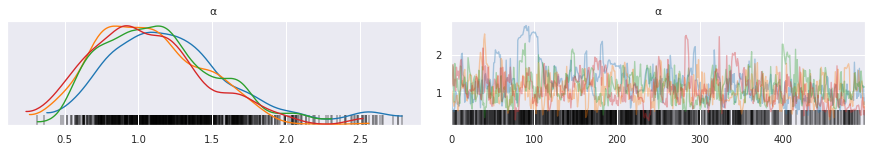

In [33]:
pm.traceplot(trace, varnames=['α'])
pass

Check that a truncation level of k=20 is sufficient.

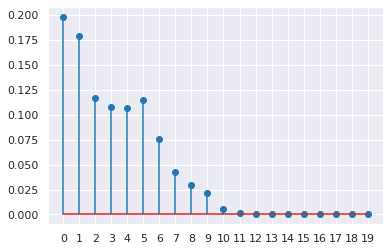

In [34]:
plt.stem(trace['p'].mean(axis=0))
plt.xticks(range(20))
pass